In [12]:
import scripts.sql_parser.sqlite_parser as sql
from scripts.sql_parser.constants import *

NC_PATH = '../../data_sets/db/northwind.db'

# instantiate parser objects based on the db path
nc = sql.SqlParser(NC_PATH)

# create a table reference for faster querying
nct = nc.table

In [13]:
# Get all Northwind tables
nc.q(sql.ALL_TABLES)

,name
0,Categories
1,sqlite_sequence
2,CustomerCustomerDemo
3,CustomerDemographics
4,Customers
5,Employees
6,EmployeeTerritories
7,Order Details
8,Orders
9,Products


In [14]:
# handle Aggregation functions

nct(name='Order Details',
    cols=['avg=UnitPrice:UP Avg',
          'max=UnitPrice:UP Max',
          'min=UnitPrice:UP Min',
          'count=UnitPrice:UP Count'])


SELECT 
	AVG(UnitPrice) AS "UP Avg",
	MAX(UnitPrice) AS "UP Max",
	MIN(UnitPrice) AS "UP Min",
	COUNT(UnitPrice) AS "UP Count"
FROM "Order Details" 


,UP Avg,UP Max,UP Min,UP Count
0,28.850379,263.5,2,609283


In [15]:
# supports most of the clauses (except GROUP BY)

nct(name='Order Details',
    cols=['UnitPrice'], distinct=True,
    where=['&20.0 >= UnitPrice <= 70.0', '|UnitPrice > 20'],
    order_by=('UnitPrice', -1),
    limit=5, offset=2)


SELECT DISTINCT 
	UnitPrice
FROM "Order Details" 
WHERE UnitPrice BETWEEN 20.0 and 70.0
	OR UnitPrice > 20
ORDER BY UnitPrice DESC
LIMIT 5 OFFSET 2


,UnitPrice
0,123.79
1,99.00
2,97.00
3,81.00
4,77.60


In [16]:
nct(name='Orders',
    cols=['ShipCountry', 'count=*:OrderCount'],
    group_by='ShipCountry',
    order_by=('OrderCount', -1),
    limit=-5)


SELECT 
	ShipCountry,
	COUNT("*") AS OrderCount
FROM Orders 
GROUP BY ShipCountry
ORDER BY OrderCount DESC
LIMIT 5


,ShipCountry,OrderCount
0,USA,2328
1,Germany,2193
2,France,1778
3,Brazil,1683
4,UK,1280


In [17]:
# simple join (between 2 tables)
nc.join(table_left={NAME: 'Customers', COLS: ['CompanyName', 'Phone', 'Fax']},
        table_right={NAME: 'Orders:o', COLS: ['ShipRegion', 'ShipCountry']},
        shared_col='CustomerID',
        join=INNER,
        limit=5)


SELECT 
	Customers.CompanyName,
	Customers.Phone,
	Customers.Fax,
	o.ShipRegion,
	o.ShipCountry
FROM Customers
INNER JOIN Orders o
ON Customers.CustomerID = o.CustomerID
LIMIT 5


,CompanyName,Phone,Fax,ShipRegion,ShipCountry
0,Vins et alcools Chevalier,26.47.15.10,26.47.15.11,Western Europe,France
1,Toms Spezialitäten,0251-031259,0251-035695,Western Europe,Germany
2,Hanari Carnes,(21) 555-0091,(21) 555-8765,South America,Brazil
3,Victuailles en stock,78.32.54.86,78.32.54.87,Western Europe,France
4,Suprêmes délices,(071) 23 67 22 20,(071) 23 67 22 21,Western Europe,Belgium


In [18]:
 # find the total sales amount for each category and supplier
nc.multi_join(
    tables=[{NAME: 'Categories:C', COLS: ['CategoryName']},
            {NAME: 'Products:P', SHARED: 'Categories.CategoryId = Products.CategoryId', JOIN: INNER},
            {NAME: 'Suppliers:S', SHARED: 'Products.SupplierID = Suppliers.SupplierID', COLS: ['CompanyName'],
             JOIN: INNER},
            {NAME: 'Order Details:OD', SHARED: 'Products.ProductID = Order Details.ProductID', COLS: [],
             JOIN: INNER}],

    col_agg={AGG_FUNC: 'sum:TotalSales',
             COLS: ['Products.UnitPrice', 'Order Details.Quantity'],
             COLS_OP: '*'},

    group_by=['Categories.CategoryName', 'Suppliers.CompanyName'],
    limit=5
)


SELECT 
	C.CategoryName,
	S.CompanyName,
	SUM(P.UnitPrice * OD.Quantity) AS TotalSales
FROM Categories C
INNER JOIN Products P ON C.CategoryId = P.CategoryId
INNER JOIN Suppliers S ON P.SupplierID = S.SupplierID
INNER JOIN "Order Details" OD ON P.ProductID = OD.ProductID
Group By C.CategoryName, S.CompanyName
LIMIT 5


,CategoryName,CompanyName,TotalSales
0,Beverages,Aux joyeux ecclésiastiques,56924965.0
1,Beverages,Bigfoot Breweries,9315500.0
2,Beverages,Exotic Liquids,7468528.0
3,Beverages,Karkki Oy,3626604.0
4,Beverages,Leka Trading,9336528.0


In [19]:
# Average Order Amount by Employee
nc.multi_join(
    tables=[{NAME: 'Employees', COLS: ['LastName']},
            {NAME: 'Orders', COLS: [], SHARED: 'Employees.EmployeeID = Orders.EmployeeID', JOIN: LEFT},
            {NAME: 'Order Details', COLS: [], SHARED: 'Orders.OrderID = Order Details.OrderID', JOIN: LEFT}],
    col_agg={AGG_FUNC: 'avg:AvgOrderAmount',
             COLS: ['Order Details.UnitPrice', 'Order Details.Quantity'],
             COLS_OP: '*'},
    group_by=['Employees.LastName'],
    order_by=('AvgOrderAmount', -1)
)


SELECT 
	Employees.LastName,
	AVG("Order Details".UnitPrice * "Order Details".Quantity) AS AvgOrderAmount
FROM Employees
LEFT JOIN Orders ON Employees.EmployeeID = Orders.EmployeeID
LEFT JOIN "Order Details" ON Orders.OrderID = "Order Details".OrderID
Group By Employees.LastName
ORDER BY AvgOrderAmount DESC


,LastName,AvgOrderAmount
0,Suyama,742.472451
1,Leverling,739.322630
2,Dodsworth,738.756131
3,King,737.349907
4,Peacock,737.154067
5,Buchanan,735.576152
6,Davolio,734.548860
7,Callahan,731.258818
8,Fuller,728.174674


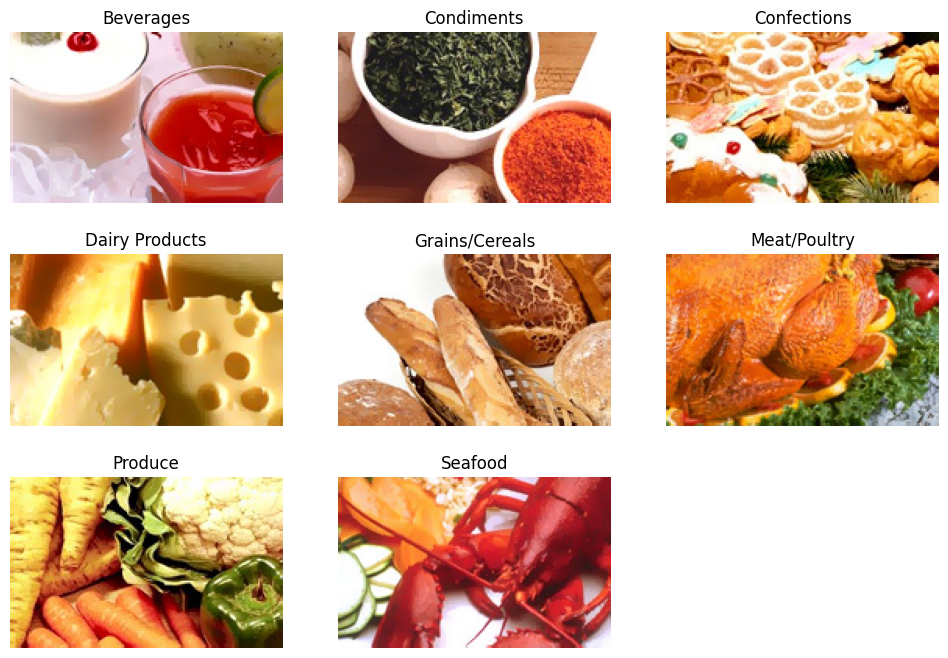

In [20]:
nc.categories_img(3)